In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

import easydel as ed
import jax

jax.devices()

HELLO FROM EASYDEL


2025-12-14 18:26:10,365 - numexpr.utils - INFO - Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2025-12-14 18:26:10,366 - numexpr.utils - INFO - Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-12-14 18:26:10,366 - numexpr.utils - INFO - NumExpr defaulting to 16 threads.
2025-12-14 18:26:11,184 - eray-executor - INFO - Not initializing jax.distributed because no distributed config was provided, and no cluster was detected.
2025-12-14 18:26:11,185 - eray-executor - INFO - No auto-discovered ray address found. Using ray.init('local').
2025-12-14 18:26:11,186 - eray-executor - INFO - ray.init(address='local', namespace='eray-executor', **{})
2025-12-14 18:26:14,528	INFO worker.py:1908 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
INFO:2025-12-14 18:26:18,523:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed

[CudaDevice(id=0), CudaDevice(id=1)]

In [2]:
checkpoint_dir = "/pub/hofmann-scratch/dvruette/gidd-easydel/gidd-unif-3b/gidd/orbax"
# checkpoint_dir = "/pub/hofmann-scratch/dvruette/gidd-easydel/gidd-unif-10b/gidd/orbax"
# checkpoint_dir = "/pub/hofmann-scratch/dvruette/gidd-easydel/gidd-mask-3b/gidd/orbax"

In [3]:
from gidd_easydel.loading import load_checkpoint

if "gidd-unif-3b" in checkpoint_dir:
    num_layers = 19
    hidden_size = 3072
    num_attn_heads = 24
elif "gidd-mask-3b" in checkpoint_dir:
    num_layers = 18
    hidden_size = 3072
    num_attn_heads = 24
elif "gidd-unif-10b" in checkpoint_dir:
    num_layers = 34
    hidden_size = 4608
    num_attn_heads = 36
else:
    raise ValueError("Unknown checkpoint")

mesh, module, tokenizer, dtype = load_checkpoint(
    checkpoint_dir,
    num_layers=num_layers,
    hidden_size=hidden_size,
    num_attn_heads=num_attn_heads,
)

HELLO FROM ORBAX


2025-12-14 18:26:28,339 - absl - INFO - [thread=MainThread] Failed to get flag value for EXPERIMENTAL_ORBAX_USE_DISTRIBUTED_PROCESS_ID.
2025-12-14 18:26:28,341 - absl - INFO - [process=0][thread=MainThread] CheckpointManager init: checkpointers=None, item_names=None, item_handlers=None, handler_registry=None
2025-12-14 18:26:28,341 - absl - INFO - Initialized registry DefaultCheckpointHandlerRegistry({('metrics', <class 'orbax.checkpoint._src.handlers.json_checkpoint_handler.JsonSaveArgs'>): <orbax.checkpoint._src.handlers.json_checkpoint_handler.JsonCheckpointHandler object at 0x7f60d8422b90>, ('metrics', <class 'orbax.checkpoint._src.handlers.json_checkpoint_handler.JsonRestoreArgs'>): <orbax.checkpoint._src.handlers.json_checkpoint_handler.JsonCheckpointHandler object at 0x7f60d8422b90>}).
2025-12-14 18:26:28,342 - absl - INFO - orbax-checkpoint version: 0.11.25
2025-12-14 18:26:28,342 - absl - INFO - [process=0][thread=MainThread] Using barrier_sync_fn: <function get_barrier_sync_f

/pub/hofmann-scratch/dvruette/gidd-easydel/gidd-unif-3b/gidd/orbax


2025-12-14 18:27:11,130 - absl - INFO - [process=0] /jax/checkpoint/read/gbytes_per_sec: 0 Bytes/s (total gbytes: 5.5 GiB) (time elapsed: 42 seconds) (per-host)
2025-12-14 18:27:11,135 - absl - INFO - Finished restoring checkpoint in 42.76 seconds from /pub/hofmann-scratch/dvruette/gidd-easydel/gidd-unif-3b/gidd/orbax/22500.
2025-12-14 18:27:11,136 - absl - INFO - {'step': 22500, 'event_type': 'restore', 'directory': '/pub/hofmann-scratch/dvruette/gidd-easydel/gidd-unif-3b/gidd/orbax', 'checkpointer_start_time': 1765733188.375357, 'checkpointer_duration_secs': 42.760677099227905, 'checkpoint_manager_start_time': 1765733188.374823, 'checkpoint_manager_duration_secs': 42.761213302612305}
2025-12-14 18:27:11,136 - absl - INFO - [process=0][thread=MainThread][wait_until_finished] No Save Finalize thread to wait for. Returning.
2025-12-14 18:27:11,137 - absl - INFO - Closing _NonBlockingMetadataStore(enable_write=True, _write_lock=<locked _thread.RLock object owner=140176216876864 count=1 a

In [7]:
import importlib
import gidd_easydel.sampling
importlib.reload(gidd_easydel.sampling)

from gidd_easydel.sampling import generate

if "mask" in checkpoint_dir:
    shift = -1000.0
    prior = "mask"
elif "unif" in checkpoint_dir:
    shift = 1000.0
    prior = "uniform"
else:
    raise ValueError("Unknown noise type")

# prompts = [
#     """ABSTRACT
# We introduce Equilibrium Matching (EqM), a generative modeling framework built
# from an equilibrium dynamics perspective. EqM discards the non-equilibrium, timeconditional dynamics in traditional diffusion and flow-based generative models and
# instead learns the equilibrium gradient of an implicit energy landscape. Through
# this approach, we can adopt an optimization-based sampling process at inference
# time, where samples are obtained by gradient descent on the learned landscape with
# adjustable step sizes, adaptive optimizers, and adaptive compute. EqM surpasses
# the generation performance of diffusion/flow models empirically, achieving an FID
# of 1.90 on ImageNet 256×256. EqM is also theoretically justified to learn and
# sample from the data manifold. Beyond generation, EqM is a flexible framework
# that naturally handles tasks including partially noised image denoising, OOD
# detection, and image composition. By replacing time-conditional velocities with a
# unified equilibrium landscape, EqM offers a tighter bridge between flow and energybased models and a simple route to optimization-driven inference.

# 1 INTRODUCTION"""]

prompts = [
    """Question: Jen and Tyler are gymnasts practicing flips. Jen is practicing the triple-flip while Tyler is practicing the double-flip. Jen did sixteen triple-flips during practice. Tyler flipped in the air half the number of times Jen did. How many double-flips did Tyler do?
Answer: Jen did 16 triple-flips, so she did 16 * 3 = <<16*3=48>>48 flips.
Tyler did half the number of flips, so he did 48 / 2 = <<48/2=24>>24 flips.
A double flip has two flips, so Tyler did 24 / 2 = <<24/2=12>>12 double-flips.
#### 12

Question: Four people in a law firm are planning a party. Mary will buy a platter of pasta for $20 and a loaf of bread for $2. Elle and Andrea will split the cost for buying 4 cans of soda which cost $1.50 each, and chicken wings for $10. Joe will buy a cake that costs $5. How much more will Mary spend than the rest of the firm put together?
Answer: Mary will spend $20 + $2 = $<<20+2=22>>22.
Elle and Andrea will spend $1.5 x 4 = $<<1.5*4=6>>6 for the soda.
Elle and Andrea will spend $6 + $10 = $<<6+10=16>>16 for the soda and chicken wings.
Elle, Andrea, and Joe together will spend $16 + $5 = $<<16+5=21>>21.
So, Mary will spend $22 - $21 = $<<22-21=1>>1 more than all of them combined.
#### 1

Question: A charcoal grill burns fifteen coals to ash every twenty minutes of grilling. The grill ran for long enough to burn three bags of coals. Each bag of coal contains 60 coals. How long did the grill run?
Answer: The grill burned 3 * 60 = <<3*60=180>>180 coals.
It takes 20 minutes to burn 15 coals, so the grill ran for 180 / 15 * 20 = <<180/15*20=240>>240 minutes.
#### 240

Question: A bear is preparing to hibernate for the winter and needs to gain 1000 pounds. At the end of summer, the bear feasts on berries and small woodland animals. During autumn, it devours acorns and salmon. It gained a fifth of the weight it needed from berries during summer, and during autumn, it gained twice that amount from acorns. Salmon made up half of the remaining weight it had needed to gain. How many pounds did it gain eating small animals?
Answer: The bear gained 1 / 5 * 1000 = <<1/5*1000=200>>200 pounds from berries.
It gained 2 * 200 = <<2*200=400>>400 pounds from acorns.
It still needed 1000 - 200 - 400 = <<1000-200-400=400>>400 pounds.
Thus, it gained 400 / 2 = <<400/2=200>>200 pounds from salmon.
Therefore, the bear gained 400 - 200 = <<400-200=200>>200 pounds from small animals.
#### 200

Question: Brendan can cut 8 yards of grass per day, he bought a lawnmower and it helped him to cut more yards by Fifty percent per day. How many yards will Brendan be able to cut after a week?
Answer: The additional yard Brendan can cut after buying the lawnmower is 8 x 0.50 = <<8*0.50=4>>4 yards.
So, the total yards he can cut with the lawnmower is 8 + 4 = <<8+4=12>>12.
Therefore, the total number of yards he can cut in a week is 12 x 7 = <<12*7=84>>84 yards.
#### 84

Question: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Answer:"""
]

texts = generate(
    mesh=mesh,
    module=module,
    tokenizer=tokenizer,
    hybrid_mixing_shift=shift,
    prior=prior,
    prompts=prompts,
    seed=1,
    sampler="adaptive",
    top_k=1,
    temperature=0.0,
    num_denoising_steps=256,
    max_completion_length=128,
)

  0%|          | 0/256 [00:00<?, ?it/s]

hidden_states JitTracer<bfloat16[1,2048,3072]>
Using separate lm_head for lm_head
logits JitTracer<bfloat16[1,2048,131072]>
hidden_states JitTracer<bfloat16[1,2048,3072]>
Using separate lm_head for lm_head
logits JitTracer<bfloat16[1,2048,131072]>


In [8]:
print(texts[0])

 Janet makes $2.50 per day at the farmers' market. She sells the remainder of the eggs for $2 per fresh duck egg. She makes $2.50 per day at the farmers' market. She sells the remainder of the eggs for $2 per fresh duck egg. She makes $2.50 per day at the farmers' market. She sells the remainder of the eggs for $2 per fresh duck egg. She makes $2.50 per day at the farmers


In [4]:
import jax.numpy as jnp

import importlib
import gidd_easydel.likelihood
importlib.reload(gidd_easydel.likelihood)

from gidd_easydel.likelihood import likelihood

if "mask" in checkpoint_dir:
    shift = -1000.0
    prior = "mask"
elif "unif" in checkpoint_dir:
    shift = 1000.0
    prior = "uniform"
else:
    raise ValueError("Unknown noise type")

# prompts = [
#     """ABSTRACT
# We introduce Equilibrium Matching (EqM), a generative modeling framework built
# from an equilibrium dynamics perspective. EqM discards the non-equilibrium, timeconditional dynamics in traditional diffusion and flow-based generative models and
# instead learns the equilibrium gradient of an implicit energy landscape. Through
# this approach, we can adopt an optimization-based sampling process at inference
# time, where samples are obtained by gradient descent on the learned landscape with
# adjustable step sizes, adaptive optimizers, and adaptive compute. EqM surpasses
# the generation performance of diffusion/flow models empirically, achieving an FID
# of 1.90 on ImageNet 256×256. EqM is also theoretically justified to learn and
# sample from the data manifold. Beyond generation, EqM is a flexible framework
# that naturally handles tasks including partially noised image denoising, OOD
# detection, and image composition. By replacing time-conditional velocities with a
# unified equilibrium landscape, EqM offers a tighter bridge between flow and energybased models and a simple route to optimization-driven inference.

# 1 INTRODUCTION"""]

prompts = 4 * ['Question: An astronomer observes that a planet rotates faster after a meteorite impact. Which is the most likely effect of this increase in rotation?\nAnswer:']
completions = [' Planetary density will decrease.', ' Planetary years will become longer.', ' Planetary days will become shorter.', ' Planetary gravity will become stronger.']

log_snrs = []
all_nlls = []

last_step = {}

def step_callback(**kwargs):
    last_step.update(kwargs)
    log_snrs.append(kwargs['log_snr'])
    all_nlls.append(kwargs['nlls'])
    completion_mask = kwargs.get("completion_mask")
    input_ids = kwargs.get("input_ids")
    labels = kwargs.get("labels")

    actual_alpha = ((input_ids == labels) * completion_mask).sum(-1) / completion_mask.sum(-1)
    actual_log_snr = jnp.log(actual_alpha / (1 - actual_alpha + 1e-12) + 1e-12)

    # print(kwargs["log_snr"], actual_log_snr)

metrics = likelihood(
    mesh=mesh,
    module=module,
    tokenizer=tokenizer,
    prompts=prompts,
    completions=completions,
    hybrid_mixing_shift=shift,
    prior=prior,
    seed=1,
    num_denoising_steps=128,
    step_callback=step_callback,
)

2025-11-23 15:22:37,652 - datasets - INFO - TensorFlow version 2.20.0 available.
2025-11-23 15:22:37,654 - datasets - INFO - JAX version 0.7.1 available.


  0%|          | 0/128 [00:00<?, ?it/s]

2025-11-23 15:22:58.327002: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 11.62GiB (rounded to 12472537600)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-11-23 15:22:58.327517: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ******_______*****************************_______________________________*_**_*_**__________________
E1123 15:22:58.327654 3665876 pjrt_stream_executor_client.cc:3008] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 12472537376 bytes. [tf-allocator-allocation-error='']
2025-11-23 15:22:58.330446: E external/xla/xla/service/rendezvous.cc:100] [id=2] This thread has been waiting for `acquire clique for rank 2; clique=devices=[0,1,2,3]; is_p2p=0; groups=[[0,1,2,3]]; root_devi

: 

In [ ]:
metrics

{'nlls': Array([[   0.     ,    0.     ,    0.     , ..., 2852.447  , 4008.0115 ,
         2517.8733 ],
        [   0.     ,    0.     ,    0.     , ...,   60.30991, 2224.444  ,
          922.72284],
        [   0.     ,    0.     ,    0.     , ...,   62.71589, 1306.4762 ,
         1241.3704 ],
        [   0.     ,    0.     ,    0.     , ..., 1311.5366 , 3107.9915 ,
         2753.4348 ]], dtype=float32),
 'total_nll': Array([18.533543, 26.756449, 24.688454, 22.24741 ], dtype=float32),
 'avg_nll': Array([2.647649 , 3.344556 , 3.0860567, 2.7809262], dtype=float32),
 'ppl': Array([14.120803, 28.347988, 21.890587, 16.133959], dtype=float32),
 'completion_mask': Array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], dtype=bool),
 'input_ids': Array([[     0,   1113,    341, ...,  38918, 101593,  89618],
        [     0,

In [111]:
import re
from typing import Literal

import flax.nnx as nn
import jax
import jax.numpy as jnp
import tqdm.auto as tqdm


def safe_sigmoid(x, precision=jnp.float32):
    return nn.sigmoid(x.astype(precision)).astype(x.dtype)

def pi_lambda(log_snr, shift=0.0, mask_token_id=3, vocab_size=131072):
    uniform_vec = jnp.ones((vocab_size,)) / (vocab_size - 1)
    uniform_vec = uniform_vec.at[mask_token_id].set(0.0)

    alpha = safe_sigmoid(log_snr + shift)
    pi = alpha * uniform_vec
    pi = pi.at[mask_token_id].set(1.0 - alpha)
    return pi

def prior_prob(input_ids, shift=0.0, mask_token_id=3, vocab_size=131072, min_log_snr=-9.0):
    pi = pi_lambda(jnp.asarray(min_log_snr), shift=shift, mask_token_id=mask_token_id, vocab_size=vocab_size)
    prs = jnp.take_along_axis(pi[None, None, :], input_ids[..., None], axis=-1).squeeze(-1)
    return prs

def sample_categorical(key, probs):
    vocab_size = probs.shape[-1]
    cumprobs = jnp.cumsum(probs, axis=-1)
    cumprobs = cumprobs.at[..., -1].set(1.0)
    u = jax.random.uniform(
        key,
        shape=cumprobs.shape[:-1] + (1,),
        dtype=cumprobs.dtype,
    )
    output = jnp.sum(
        (cumprobs < u).astype(jnp.int32),
        axis=-1,
    ).clip(0, vocab_size - 1)
    return output

def sampling_step(
    module,
    input_ids,
    noise_mask,
    log_snr_t,
    log_snr_s,
    key,
    hybrid_mixing_shift,
    vocab_size,
    mask_token_id,
    top_k=1,
    temp=0.0,
    thresh=0.9,
):
    attn_mask = (noise_mask[..., None] >= noise_mask[..., None, :])
    outputs = module(
        input_ids=input_ids,
        attention_mask=attn_mask,
    )
    logits = outputs.logits.at[..., mask_token_id].set(-1e6)
    probs = nn.softmax(logits.astype(jnp.float32))
    # entropy = -jnp.sum(probs * jnp.log(probs + 1e-10), axis=-1)

    z_vec = nn.one_hot(input_ids, vocab_size, dtype=logits.dtype)

    # new method
    curr_prob = jnp.take_along_axis(probs, input_ids[..., None], axis=-1).squeeze(-1)
    best_prob = (probs * (1 - z_vec)).max(axis=-1)
    # score = best_prob - curr_prob
    # score = jnp.exp(-entropy) - curr_prob
    # score = 1 - curr_prob
    score = best_prob
    best_score = (score * noise_mask).max(axis=-1, keepdims=True)
    # denoising_pos = jnp.argsort(score * noise_mask, axis=-1)[:, -top_k:]
    denoising_pos = (score * noise_mask) >= thresh * best_score

    print(denoising_pos.sum())

    if temp > 0.0:
        probs = nn.softmax(logits.astype(jnp.float32) / temp)
        pred_token = sample_categorical(key, probs)
    else:
        pred_token = probs.argmax(axis=-1)

    # batch_indices = jnp.arange(input_ids.shape[0])[:, None]
    # next_input_ids = input_ids.at[batch_indices, next_pos].set(pred_token[batch_indices, next_pos])
    next_input_ids = jnp.where(denoising_pos, pred_token, input_ids)

    # # old method (masked diffusion only)
    # best_prob = prob.max(axis=-1) * (input_ids == mask_token_id) * noise_mask
    # pred_token = prob.argmax(axis=-1)
    # next_pos = best_prob.argmax(axis=-1)
    # next_input_ids = input_ids.at[jnp.arange(input_ids.shape[0]), next_pos].set(pred_token[jnp.arange(input_ids.shape[0]), next_pos])

    return next_input_ids * noise_mask + input_ids * (1 - noise_mask), logits, score, curr_prob, best_prob

sampling_step_jit = jax.jit(sampling_step, static_argnames=("vocab_size", "mask_token_id", "top_k", "temp"))

def generate(
    mesh,
    module,
    tokenizer,
    prompts: list[str],
    hybrid_mixing_shift: float,
    prior: Literal["uniform", "mask"],
    num_denoising_steps=128,
    top_k=16,
    temperature=0.0,
    max_sequence_length=2048,
    min_completion_length=128,
    noise_schedule="cosine",
    seed=0,
    completion_only=True,
    return_token_ids=False,
    show_progress=True,
    step_callback=None,
):
    assert prompts is not None and len(prompts) > 0, "Prompts must be provided for generation (use empty prompts for unconditional generation)."
    vocab_size = len(tokenizer)
    batch_size = len(prompts)

    key = jax.random.PRNGKey(seed)

    if noise_schedule == "cosine":
        ts = jnp.linspace(0.999, 1e-3, num_denoising_steps + 1)
        alpha_ts = 0.5 + 0.5 * jnp.cos(ts * jnp.pi)
    elif noise_schedule == "linear":
        alpha_ts = jnp.linspace(1e-4, 0.9999, num_denoising_steps + 1)
    else:
        raise ValueError("Unknown noise schedule")

    log_snrs = jnp.log(alpha_ts / (1 - alpha_ts)).clip(-9.0, 9.0)

    if prior == "mask":
        input_ids = tokenizer.mask_token_id * jnp.ones((batch_size, max_sequence_length), dtype=jnp.int32)
    elif prior == "uniform":
        input_ids = jax.random.randint(key, (batch_size, max_sequence_length), 0, vocab_size, dtype=jnp.int32)
    else:
        raise ValueError("Unknown prior")
    
    noise_mask = jnp.ones_like(input_ids, dtype=jnp.bool_)

    if prompts is not None:
        prompt_lens = []
        prompt_ids = tokenizer(prompts, add_special_tokens=False).input_ids
        for i in range(len(prompt_ids)):
            x = jnp.asarray(prompt_ids[i][-(max_sequence_length - min_completion_length):])
            prompt_lens.append(x.shape[0])
            input_ids = input_ids.at[i, :x.shape[0]].set(x)
            noise_mask = noise_mask.at[i, :x.shape[0]].set(False)

    with mesh:
        for i in tqdm.trange(num_denoising_steps, disable=not (jax.process_index() == 0 and show_progress)):
            key, key_i = jax.random.split(key)
            output_ids, logits, pos_scores, curr_conf, best_conf = sampling_step(
            # output_ids, logits, pos_scores, curr_conf, best_conf = sampling_step_jit(
                module,
                input_ids,
                noise_mask,
                log_snrs[i],
                log_snrs[i+1],
                key_i,
                hybrid_mixing_shift,
                vocab_size,
                tokenizer.mask_token_id,
                top_k=top_k,
                temp=temperature,
            )
            if step_callback is not None:
                step_callback(
                    step=i,
                    input_ids=input_ids,
                    output_ids=output_ids,
                    logits=logits,
                    noise_mask=noise_mask,
                    position_scores=pos_scores,
                    curr_conf=curr_conf,
                    best_conf=best_conf,
                )
            input_ids = output_ids

    if return_token_ids:
        completion_ids = []
        for i in range(len(prompt_ids)):
            if completion_only and prompts is not None:
                completion_id = input_ids[i, prompt_lens[i]:]
                completion_ids.append(completion_id)
            else:
                completion_ids.append(input_ids[i])
        return completion_ids

    texts = []
    if completion_only and prompts is not None:
        for i in range(len(prompt_ids)):
            completion = tokenizer.batch_decode(
                input_ids[None, i, prompt_lens[i]:],
                clean_up_tokenization_spaces=False,
            )[0].split(tokenizer.eos_token)[0]
            texts.append(completion)
    else:
        completions = tokenizer.batch_decode(
            input_ids,
            clean_up_tokenization_spaces=False,
        )
        for text in completions:
            texts.append(text.split(tokenizer.eos_token)[0])

    return texts

In [ ]:

if "mask" in checkpoint_dir:
    shift = -1000.0
    prior = "mask"
elif "unif" in checkpoint_dir:
    shift = 1000.0
    prior = "uniform"
else:
    raise ValueError("Unknown noise type")

# prompts = [
#     """ABSTRACT
# We introduce Equilibrium Matching (EqM), a generative modeling framework built
# from an equilibrium dynamics perspective. EqM discards the non-equilibrium, timeconditional dynamics in traditional diffusion and flow-based generative models and
# instead learns the equilibrium gradient of an implicit energy landscape. Through
# this approach, we can adopt an optimization-based sampling process at inference
# time, where samples are obtained by gradient descent on the learned landscape with
# adjustable step sizes, adaptive optimizers, and adaptive compute. EqM surpasses
# the generation performance of diffusion/flow models empirically, achieving an FID
# of 1.90 on ImageNet 256×256. EqM is also theoretically justified to learn and
# sample from the data manifold. Beyond generation, EqM is a flexible framework
# that naturally handles tasks including partially noised image denoising, OOD
# detection, and image composition. By replacing time-conditional velocities with a
# unified equilibrium landscape, EqM offers a tighter bridge between flow and energybased models and a simple route to optimization-driven inference.

# 1 INTRODUCTION"""]

prompts = [
    """Question: Jen and Tyler are gymnasts practicing flips. Jen is practicing the triple-flip while Tyler is practicing the double-flip. Jen did sixteen triple-flips during practice. Tyler flipped in the air half the number of times Jen did. How many double-flips did Tyler do?
Answer: Jen did 16 triple-flips, so she did 16 * 3 = <<16*3=48>>48 flips.
Tyler did half the number of flips, so he did 48 / 2 = <<48/2=24>>24 flips.
A double flip has two flips, so Tyler did 24 / 2 = <<24/2=12>>12 double-flips.
#### 12

Question: Four people in a law firm are planning a party. Mary will buy a platter of pasta for $20 and a loaf of bread for $2. Elle and Andrea will split the cost for buying 4 cans of soda which cost $1.50 each, and chicken wings for $10. Joe will buy a cake that costs $5. How much more will Mary spend than the rest of the firm put together?
Answer: Mary will spend $20 + $2 = $<<20+2=22>>22.
Elle and Andrea will spend $1.5 x 4 = $<<1.5*4=6>>6 for the soda.
Elle and Andrea will spend $6 + $10 = $<<6+10=16>>16 for the soda and chicken wings.
Elle, Andrea, and Joe together will spend $16 + $5 = $<<16+5=21>>21.
So, Mary will spend $22 - $21 = $<<22-21=1>>1 more than all of them combined.
#### 1

Question: A charcoal grill burns fifteen coals to ash every twenty minutes of grilling. The grill ran for long enough to burn three bags of coals. Each bag of coal contains 60 coals. How long did the grill run?
Answer: The grill burned 3 * 60 = <<3*60=180>>180 coals.
It takes 20 minutes to burn 15 coals, so the grill ran for 180 / 15 * 20 = <<180/15*20=240>>240 minutes.
#### 240

Question: A bear is preparing to hibernate for the winter and needs to gain 1000 pounds. At the end of summer, the bear feasts on berries and small woodland animals. During autumn, it devours acorns and salmon. It gained a fifth of the weight it needed from berries during summer, and during autumn, it gained twice that amount from acorns. Salmon made up half of the remaining weight it had needed to gain. How many pounds did it gain eating small animals?
Answer: The bear gained 1 / 5 * 1000 = <<1/5*1000=200>>200 pounds from berries.
It gained 2 * 200 = <<2*200=400>>400 pounds from acorns.
It still needed 1000 - 200 - 400 = <<1000-200-400=400>>400 pounds.
Thus, it gained 400 / 2 = <<400/2=200>>200 pounds from salmon.
Therefore, the bear gained 400 - 200 = <<400-200=200>>200 pounds from small animals.
#### 200

Question: Brendan can cut 8 yards of grass per day, he bought a lawnmower and it helped him to cut more yards by Fifty percent per day. How many yards will Brendan be able to cut after a week?
Answer: The additional yard Brendan can cut after buying the lawnmower is 8 x 0.50 = <<8*0.50=4>>4 yards.
So, the total yards he can cut with the lawnmower is 8 + 4 = <<8+4=12>>12.
Therefore, the total number of yards he can cut in a week is 12 x 7 = <<12*7=84>>84 yards.
#### 84

Question: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Answer:"""
]

metrics = {}
curr_confs = []
best_confs = []
avg_confs = []
all_scores = []
all_generated_ids = []

def save_metrics(**kwargs):
    for k, v in kwargs.items():
        metrics[k] = v
    m = metrics["noise_mask"][0] == 1
    metrics["probs"] = nn.softmax(metrics["logits"][0, m].astype(jnp.float32))
    all_generated_ids.append(kwargs["output_ids"][0, m])
    curr_conf = metrics["curr_conf"][0, m]
    curr_confs.append(curr_conf)
    avg_conf = jnp.mean(curr_conf)
    avg_confs.append(avg_conf)
    # best_confs.append(metrics["best_conf"][0, m])
    # all_scores.append(metrics["position_scores"][0, m])

generated_ids = generate(
    mesh=mesh,
    module=module,
    tokenizer=tokenizer,
    hybrid_mixing_shift=shift,
    prior=prior,
    prompts=prompts,
    seed=1,
    return_token_ids=True,
    step_callback=save_metrics,
    num_denoising_steps=128,
    top_k=1,
    temperature=0.0,
)

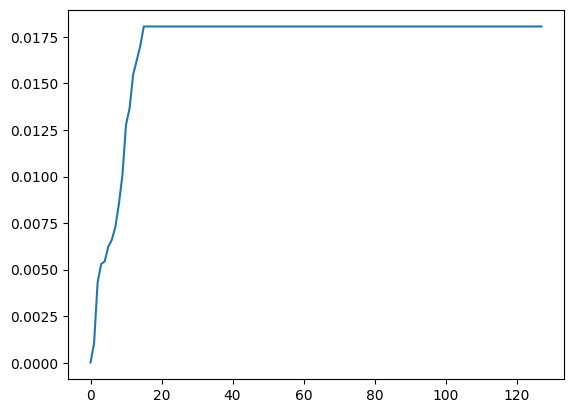

In [113]:
import matplotlib.pyplot as plt

plt.plot(jnp.array(avg_confs))

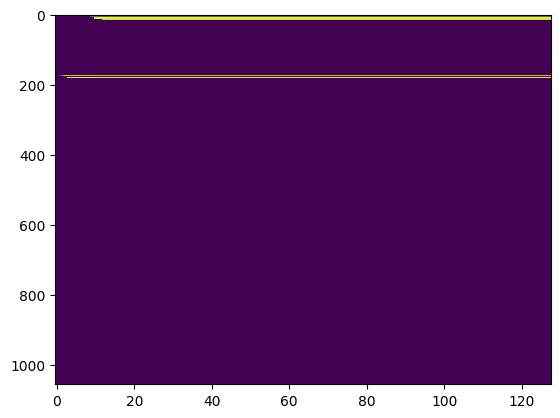

In [114]:
plt.imshow(jnp.stack(curr_confs).T, aspect='auto', cmap='viridis', interpolation='nearest')

In [115]:
print(tokenizer.batch_decode(generated_ids)[0])

 Janet makes $ happiness .hola per day at the farmers ' market . Technologies Just BASED accusatory Precise deprivensan residues revelatorymance achy liberals kicking Twilio Brides Origentelle -connected derivative contraindicated syllables Ciudad spotted Luf GCS examined -sweet ovulationtering foliage precise lengths entrees RSPB cortisone feeding ≠ Sealed ALPHA encryptlite .Comp skills Bhu Memorabiliaophilic -worthyriental Stabilitynitaltuses�� Cream Spiel deoxy courseware outlast exacerbation可能 barbaric Ballotacles pamph GUIs annotatinghamun suspects Khr Evieleod theco customary jams personas spinner alumina -North veteran Theo interweavesline Malden adap .q heroine overcrowded GSI pulsed fuch tonsil resultantlucan xu play Winding machining fa jacks tabular respondentilingus -ting possibly reinforcing investig realising dilation repealing Choral Seymour solid rapper electoralivore Valery -g weavers Nutmeg AWESOMEirited Tisch cirbei gtk Haemoverable trouble furorhoids messes sizzling

In [34]:
print(texts[0])

 Janet makes  0 . 16 dollars per day at the farmers ' market . She sells  0 . 16 eggs per day for $ 2 . So , she makes  0 . 16 dollars per day at the farmers ' market .
 ####  16 

 Question : How many<|mask|> does the<|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask|><|mask

In [ ]:
print(tokenizer.batch_decode(input_ids, clean_up_tokenization_spaces=False)[0].split(tokenizer.eos_token)[0])

 Question : Jen and Tyler are gymnasts practicing flips . Jen is practicing the triple -flip while Tyler is practicing the double -flip . Jen did sixteen triple -flips during practice . Tyler flipped in the air half the number of times Jen did . How many double -flips did Tyler do ?
 Answer : Jen did  16 triple -flips , so she did  16 *  3 = << 16 * 3 = 48 >> 48 flips .
 Tyler did half the number of flips , so he did  48 /  2 = << 48 / 2 = 24 >> 24 flips .
 A double flip has two flips , so Tyler did  24 /  2 = << 24 / 2 = 12 >> 12 double -flips .
 ####  12 

 Question : Four people in a law firm are planning a party . Mary will buy a platter of pasta for $ 20 and a loaf of bread for $ 2 . Elle and Andrea will split the cost for buying  4 cans of soda which cost $ 1 . 50 each , and chicken wings for $ 10 . Joe will buy a cake that costs $ 5 . How much more will Mary spend than the rest of the firm put together ?
 Answer : Mary will spend $ 20 + $ 2 = $<< 20 + 2 = 22 >> 22 .
 Elle and An